In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CPS-Based

In [ ]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm

# Paths
gt_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/gt.json"
cps_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/3D_50_keypoints_cps.json"
yolo_label_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"
output_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json"

# Camera intrinsics (LINEMOD)
CAM_K = np.array([
    [572.4114, 0.0, 325.2611],
    [0.0, 573.57043, 242.04899],
    [0.0, 0.0, 1.0]
])

image_size = (256, 256)
all_keypoints_2D = {}
skipped = 0

with open(gt_json_path, 'r') as f:
    gt_data = json.load(f)
with open(cps_json_path, 'r') as f:
    cps_data = json.load(f)

for image_key, (R_list, T, _) in tqdm(gt_data.items()):
    try:
        class_name = image_key.split('_')[0]  # e.g., '01'

        if class_name not in cps_data:
            skipped += 1
            continue

        # Load YOLO predicted bbox
        label_path = os.path.join(yolo_label_dir, f"{image_key}.txt")
        if not os.path.exists(label_path):
            skipped += 1
            continue

        with open(label_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                skipped += 1
                continue

            pred_class, xc, yc, w, h = map(float, line.split())
            x = (xc - w / 2) * 640
            y = (yc - h / 2) * 480
            w *= 640
            h *= 480

        # Get 3D keypoints
        keypoints_3D = np.array(cps_data[class_name], dtype=np.float32)

        # Compute 2D projections
        R = np.array(R_list).reshape(3, 3)
        rvec, _ = cv2.Rodrigues(R)
        T = np.array(T).reshape(3, 1)
        keypoints_2D, _ = cv2.projectPoints(keypoints_3D, rvec, T, CAM_K, None)
        keypoints_2D = keypoints_2D.squeeze()

        # Normalize into YOLO-cropped 256×256 frame
        scale_x = image_size[0] / w
        scale_y = image_size[1] / h
        keypoints_scaled = []
        for u, v in keypoints_2D:
            cx = (u - x) * scale_x
            cy = (v - y) * scale_y
            keypoints_scaled.append([float(cx), float(cy)])

        all_keypoints_2D[image_key] = keypoints_scaled

    except Exception as e:
        print(f"[ERROR] {image_key}: {str(e)}")
        skipped += 1

# Save output
with open(output_json_path, 'w') as f:
    json.dump(all_keypoints_2D, f, indent=2)

print(f"\n✅ YOLO-based projection complete.")
print(f"🔢 Saved: {len(all_keypoints_2D)}, Skipped: {skipped}")
print(f"📄 Output JSON: {output_json_path}")

100%|██████████| 14220/14220 [00:45<00:00, 314.18it/s]



✅ YOLO-based projection complete.
🔢 Saved: 14220, Skipped: 0
📄 Output JSON: /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json


In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt

def visualize_one_per_class(json_path, image_dir, image_size=(256, 256), max_classes=None):
    """
    Visualize one image per class by overlaying 2D keypoints.

    Parameters:
        json_path (str): Path to the 2D keypoints JSON file.
        image_dir (str): Directory containing cropped images (.png).
        image_size (tuple): Expected image resolution (width, height).
        max_classes (int or None): Optional maximum number of classes to show.
    """
    with open(json_path, "r") as f:
        keypoints_data = json.load(f)

    shown_classes = set()

    for key, keypoints in sorted(keypoints_data.items()):
        class_name = key.split('_')[0]  # e.g., '01', '02'

        if class_name in shown_classes:
            continue

        img_path = os.path.join(image_dir, f"{key}.png")
        if not os.path.exists(img_path):
            print(f"[ERROR] Missing image: {img_path}")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"[ERROR] Failed to load image: {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)

        for x, y in keypoints:
            cv2.circle(image, (int(round(x)), int(round(y))), 4, (255, 0, 0), -1)

        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Class {class_name} — {key}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        shown_classes.add(class_name)

        if max_classes and len(shown_classes) >= max_classes:
            break

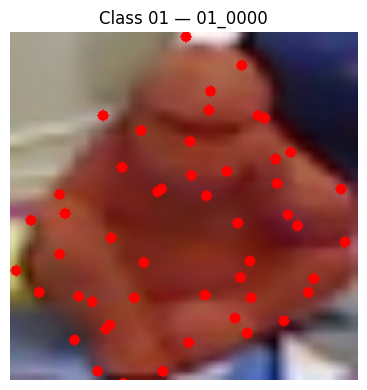

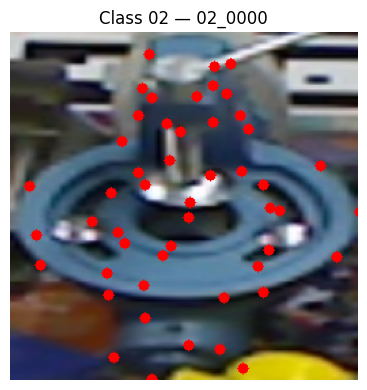

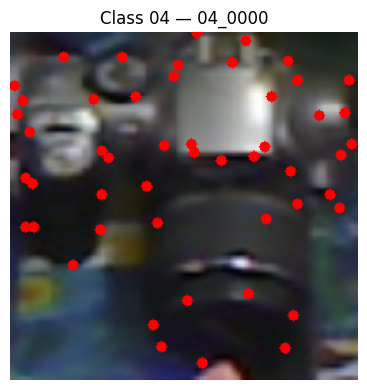

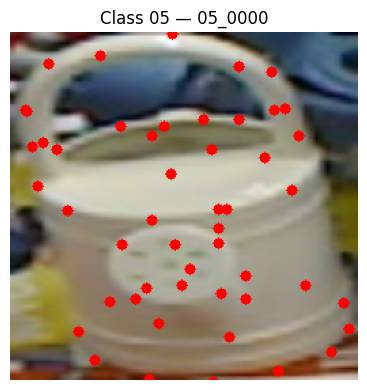

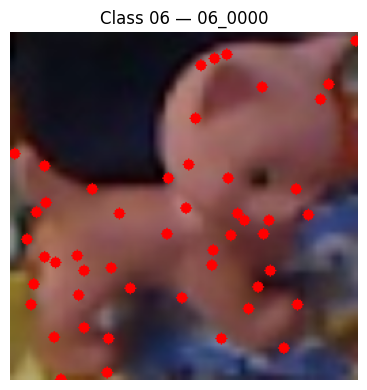

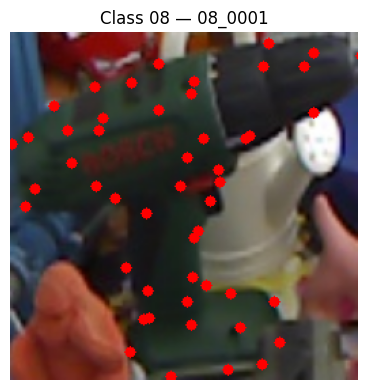

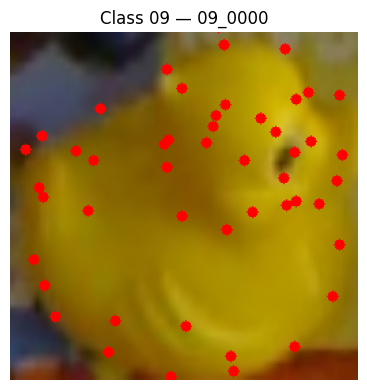

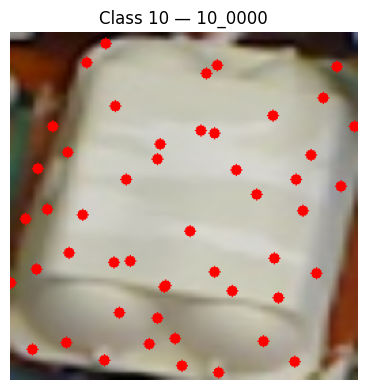

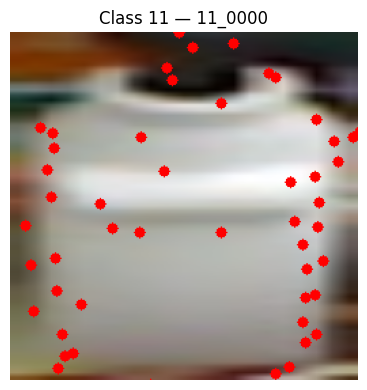

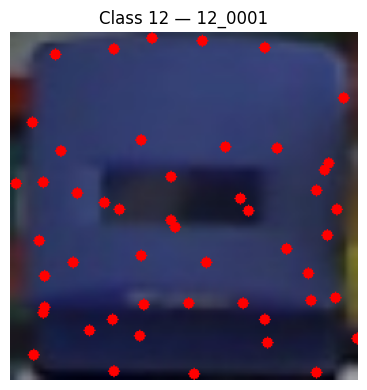

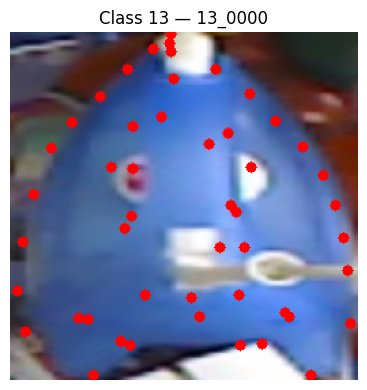

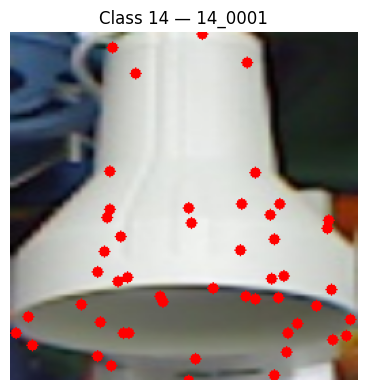

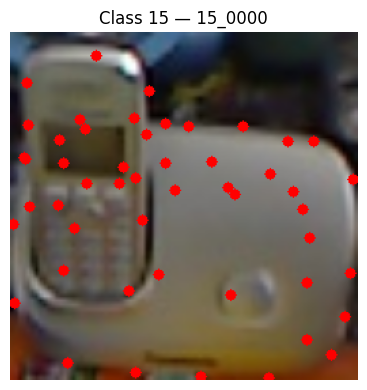

In [ ]:
visualize_one_per_class(
    json_path="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json",
    image_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data/",
    image_size=(256, 256)
)

# FPS-Based

In [ ]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm

def project_fps_keypoints_yolo_scaled(
    gt_path,
    fps_keypoint_json_path,
    yolo_label_dir,
    cam_K,
    output_json_path,
    image_size=(256, 256)
):
    with open(gt_path, 'r') as f:
        gt_data = json.load(f)
    with open(fps_keypoint_json_path, 'r') as f:
        keypoints_3D_data = json.load(f)

    all_keypoints_2D = {}
    skipped = 0

    for image_key, (R_list, T, _) in tqdm(gt_data.items()):
        try:
            class_str = image_key.split('_')[0]
            if class_str not in keypoints_3D_data:
                skipped += 1
                continue

            # Load YOLO bbox prediction
            label_path = os.path.join(yolo_label_dir, f"{image_key}.txt")
            if not os.path.exists(label_path):
                skipped += 1
                continue

            with open(label_path, 'r') as f:
                line = f.readline().strip()
                if not line:
                    skipped += 1
                    continue

                pred_class, xc, yc, w, h = map(float, line.split())
                x = (xc - w / 2) * 640
                y = (yc - h / 2) * 480
                w *= 640
                h *= 480

            # Project 3D → 2D
            keypoints_3D = np.array(keypoints_3D_data[class_str], dtype=np.float32)
            R = np.array(R_list).reshape(3, 3)
            rvec, _ = cv2.Rodrigues(R)
            T = np.array(T).reshape(3, 1)

            keypoints_2D, _ = cv2.projectPoints(keypoints_3D, rvec, T, cam_K, None)
            keypoints_2D = keypoints_2D.squeeze()

            # Scale to YOLO crop (256×256)
            scale_x = image_size[0] / w
            scale_y = image_size[1] / h

            keypoints_scaled = []
            for u, v in keypoints_2D:
                cx = (u - x) * scale_x
                cy = (v - y) * scale_y
                keypoints_scaled.append([float(cx), float(cy)])

            all_keypoints_2D[image_key] = keypoints_scaled

        except Exception as e:
            print(f"[ERROR] {image_key}: {str(e)}")
            skipped += 1

    with open(output_json_path, 'w') as f:
        json.dump(all_keypoints_2D, f, indent=2)

    print(f"\n✅ YOLO-scaled projection complete for FPS.")
    print(f"🔢 Saved: {len(all_keypoints_2D)}, Skipped: {skipped}")
    print(f"📄 Output JSON: {output_json_path}")

In [ ]:
project_fps_keypoints_yolo_scaled(
    gt_path="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/gt.json",
    fps_keypoint_json_path="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/3D_50_keypoints_fps.json",
    yolo_label_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels",
    cam_K=np.array([
        [572.4114, 0.0, 325.2611],
        [0.0, 573.57043, 242.04899],
        [0.0, 0.0, 1.0]
    ]),
    output_json_path="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json"
)

100%|██████████| 14220/14220 [00:43<00:00, 330.34it/s]



✅ YOLO-scaled projection complete for FPS.
🔢 Saved: 14220, Skipped: 0
📄 Output JSON: /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json


FPS Vs CPS

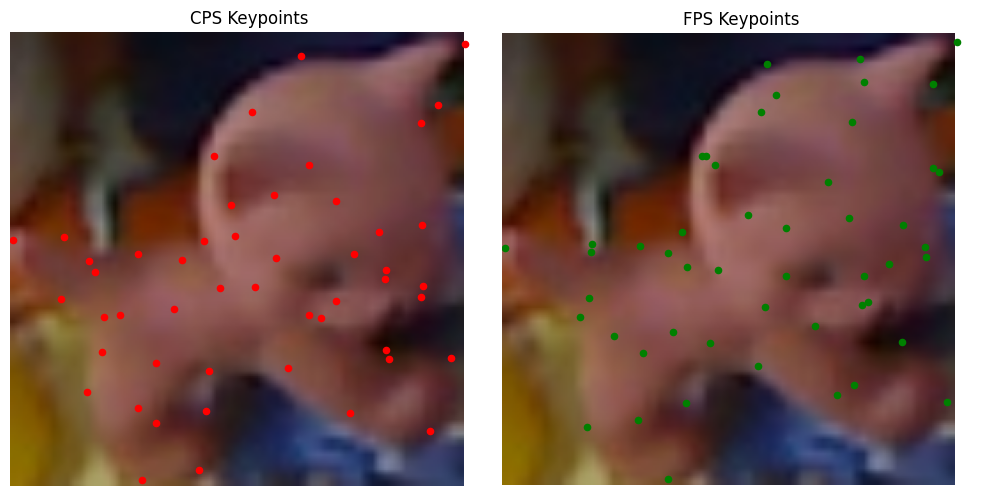

In [12]:
import os
import json
import cv2
import matplotlib.pyplot as plt

# === SETTINGS ===
image_id = "06_0128"
image_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data/{image_id}.png"

cps_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json"
fps_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json"

# === Load image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Load keypoints
with open(cps_json_path, 'r') as f:
    cps_kps = json.load(f)

with open(fps_json_path, 'r') as f:
    fps_kps = json.load(f)

cps_points = cps_kps[image_id]
fps_points = fps_kps[image_id]

# === Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = ['CPS Keypoints', 'FPS Keypoints']
keypoint_sets = [cps_points, fps_points]

colors = ['red', 'green']  # CPS = red, FPS = green

for i in range(2):
    axs[i].imshow(img_rgb)
    axs[i].scatter(*zip(*keypoint_sets[i]), color=colors[i], s=20)
    axs[i].set_title(titles[i])
    axs[i].axis('off')


plt.tight_layout()
plt.show()

# Heatmap Extraction

## CPS-Based

In [ ]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm

# Input/output paths
input_json = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json"
output_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps"
os.makedirs(output_dir, exist_ok=True)

# Constants
image_size = (256, 256)
heatmap_size = (64, 64)
sigma = 2.0

# Helper: scale coordinates from original image size to heatmap size
def scale_coords(coords, orig_size=(256, 256), target_size=(64, 64)):
    sx = target_size[1] / orig_size[1]
    sy = target_size[0] / orig_size[0]
    return [(x * sx, y * sy) for (x, y) in coords]

# Helper: generate a 2D Gaussian heatmap centered at a keypoint
def generate_heatmap(center, shape, sigma):
    x = torch.arange(shape[1]).view(1, -1).expand(shape)
    y = torch.arange(shape[0]).view(-1, 1).expand(shape)
    d2 = (x - center[0])**2 + (y - center[1])**2
    return torch.exp(-d2 / (2 * sigma**2))

# Load 2D keypoints
with open(input_json, 'r') as f:
    keypoints_2d = json.load(f)

# Main loop: generate heatmaps per image
for image_id, coords in tqdm(keypoints_2d.items()):
    if not coords or len(coords) == 0:
        continue

    scaled_kps = scale_coords(coords, image_size, heatmap_size)

    try:
        heatmaps = torch.stack([
            generate_heatmap(kp, shape=heatmap_size, sigma=sigma)
            for kp in scaled_kps
        ])  # shape: (N_keypoints, 64, 64)

        torch.save(heatmaps, os.path.join(output_dir, f"{image_id}.pt"))

    except Exception as e:
        print(f"[ERROR] {image_id}: {str(e)}")

print(f"\n✅ All heatmaps generated and saved to: {output_dir}")

100%|██████████| 14220/14220 [04:35<00:00, 51.62it/s]


✅ All heatmaps generated and saved to: /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_cps_based_on_50_keypoints


In [ ]:
import os
import torch
import json
import numpy as np
from tqdm import tqdm

# Input/output paths
heatmap_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps"
output_json = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_preds_from_heatmaps_cps.json"

# Constants
heatmap_size = (64, 64)
output_size = (256, 256)
scale_x = output_size[0] / heatmap_size[0]
scale_y = output_size[1] / heatmap_size[1]

# Storage
predicted_keypoints = {}

# Main loop
for filename in tqdm(sorted(os.listdir(heatmap_dir))):
    if not filename.endswith(".pt"):
        continue

    image_id = filename.replace(".pt", "")
    heatmap_path = os.path.join(heatmap_dir, filename)

    try:
        heatmap = torch.load(heatmap_path)  # shape: (N_keypoints, 64, 64)
        keypoints = []

        for i in range(heatmap.shape[0]):
            h = heatmap[i]
            y, x = np.unravel_index(torch.argmax(h).item(), h.shape)
            x_rescaled = x * scale_x
            y_rescaled = y * scale_y
            keypoints.append([float(x_rescaled), float(y_rescaled)])

        predicted_keypoints[image_id] = keypoints

    except Exception as e:
        print(f"[ERROR] Failed to load or process {filename}: {str(e)}")

# Save results
with open(output_json, "w") as f:
    json.dump(predicted_keypoints, f, indent=2)

print(f"\n✅ Extracted keypoints saved to:\n{output_json}")

100%|██████████| 14220/14220 [04:49<00:00, 49.10it/s]



✅ Extracted keypoints saved to:
/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_preds_from_heatmaps_cps.json


## FPS_Based

In [ ]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm

# Parameters
input_json = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json"
output_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_fps"
os.makedirs(output_dir, exist_ok=True)

image_size = (256, 256)
heatmap_size = (64, 64)
sigma = 2.0

# Step 1: scale 256x256 → 64x64
def scale_coords(coords, orig_size=(256, 256), target_size=(64, 64)):
    sx = target_size[1] / orig_size[1]
    sy = target_size[0] / orig_size[0]
    return [(x * sx, y * sy) for (x, y) in coords]

# Step 2: generate 2D Gaussian heatmap
def generate_heatmap(center, shape, sigma):
    x_grid = torch.arange(shape[1]).view(1, -1).expand(shape)
    y_grid = torch.arange(shape[0]).view(-1, 1).expand(shape)
    d2 = (x_grid - center[0])**2 + (y_grid - center[1])**2
    return torch.exp(-d2 / (2 * sigma**2))

# Load input keypoints
with open(input_json, 'r') as f:
    keypoints_2d = json.load(f)

# Step 3: main loop
for image_id, coords in tqdm(keypoints_2d.items()):
    if not coords or len(coords) == 0:
        continue

    scaled_kps = scale_coords(coords, image_size, heatmap_size)

    try:
        heatmaps = torch.stack([
            generate_heatmap(kp, shape=heatmap_size, sigma=sigma)
            for kp in scaled_kps
        ])  # shape: (N_keypoints, 64, 64)

        torch.save(heatmaps, os.path.join(output_dir, f"{image_id}.pt"))

    except Exception as e:
        print(f"[ERROR] {image_id}: {str(e)}")

print(f"\n✅ All FPS heatmaps saved to: {output_dir}")

100%|██████████| 14220/14220 [04:47<00:00, 49.50it/s]


✅ All FPS heatmaps saved to: /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_fps_based_on_50_keypoints


In [ ]:
import os
import torch
import json
import numpy as np
from tqdm import tqdm

# Input/output paths
heatmap_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_fps"
output_json = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_keypoints_preds_from_heatmaps_fps.json"

# Constants
heatmap_size = (64, 64)
output_size = (256, 256)
scale_x = output_size[0] / heatmap_size[0]
scale_y = output_size[1] / heatmap_size[1]

# Storage
predicted_keypoints = {}

# Main loop
for filename in tqdm(sorted(os.listdir(heatmap_dir))):
    if not filename.endswith(".pt"):
        continue

    image_id = filename.replace(".pt", "")
    heatmap_path = os.path.join(heatmap_dir, filename)

    try:
        heatmap = torch.load(heatmap_path)  # shape: (N_keypoints, 64, 64)
        keypoints = []

        for i in range(heatmap.shape[0]):
            h = heatmap[i]
            y, x = np.unravel_index(torch.argmax(h).item(), h.shape)
            x_rescaled = x * scale_x
            y_rescaled = y * scale_y
            keypoints.append([float(x_rescaled), float(y_rescaled)])

        predicted_keypoints[image_id] = keypoints

    except Exception as e:
        print(f"[ERROR] Failed to load/process {filename}: {str(e)}")

# Save results
with open(output_json, "w") as f:
    json.dump(predicted_keypoints, f, indent=2)

print(f"\n✅ Extracted keypoints saved to:\n{output_json}")

100%|██████████| 14220/14220 [05:06<00:00, 46.34it/s] 



✅ Extracted keypoints saved to:
/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_keypoints_preds_from_heatmaps_fps.json


# Heatmaps Exploration

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

In [ ]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_heatmaps(image_id, heatmap_dir, cols=4, cmap="hot"):
    """
    Visualizes all heatmaps for a given image_id from the specified directory.
    """
    path = os.path.join(heatmap_dir, f"{image_id}.pt")
    if not os.path.exists(path):
        print(f"[ERROR] Heatmap not found: {path}")
        return

    heatmaps = torch.load(path)
    num = heatmaps.shape[0]
    rows = (num + cols - 1) // cols

    plt.figure(figsize=(3 * cols, 3 * rows))
    for i in range(num):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(heatmaps[i].numpy(), cmap=cmap)
        plt.title(f"Keypoint {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle(f"Heatmaps for {image_id}", fontsize=16, y=1.02)
    plt.show()


def extract_keypoints_from_heatmaps(heatmaps, scale=4.0):
    """
    Extracts keypoint coordinates (rescaled to 256×256) from given heatmaps.
    """
    keypoints = []
    for i in range(heatmaps.shape[0]):
        y, x = np.unravel_index(torch.argmax(heatmaps[i]).item(), heatmaps[i].shape)
        keypoints.append([x * scale, y * scale])
    return keypoints


def compare_keypoints(image_id, heatmap_dir, image_dir, keypoints_json):
    """
    Compares ground truth and predicted keypoints by overlaying them on the image.
    """
    heatmap_path = os.path.join(heatmap_dir, f"{image_id}.pt")
    image_path = os.path.join(image_dir, f"{image_id}.png")

    if not os.path.exists(heatmap_path):
        print(f"[ERROR] Missing heatmap: {heatmap_path}")
        return
    if not os.path.exists(image_path):
        print(f"[ERROR] Missing image: {image_path}")
        return

    heatmaps = torch.load(heatmap_path)
    pred_kps = extract_keypoints_from_heatmaps(heatmaps)

    with open(keypoints_json, 'r') as f:
        gt_data = json.load(f)
    if image_id not in gt_data:
        print(f"[ERROR] No GT keypoints for: {image_id}")
        return

    gt_kps = gt_data[image_id]
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to read image: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw GT (green) and Predicted (red) keypoints
    for x, y in gt_kps:
        cv2.circle(image, (int(round(x)), int(round(y))), 3, (0, 255, 0), -1)
    for x, y in pred_kps:
        cv2.circle(image, (int(round(x)), int(round(y))), 3, (255, 0, 0), 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"{image_id} — GT (green) vs Pred (red)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

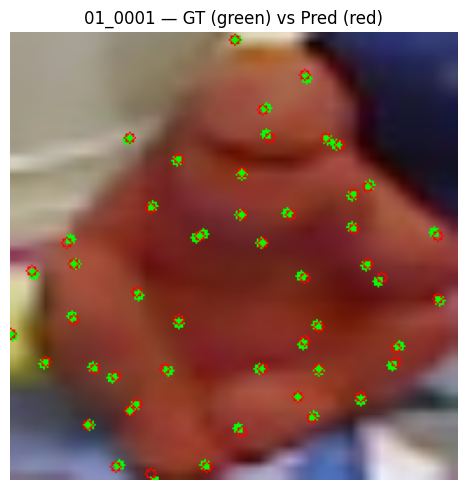

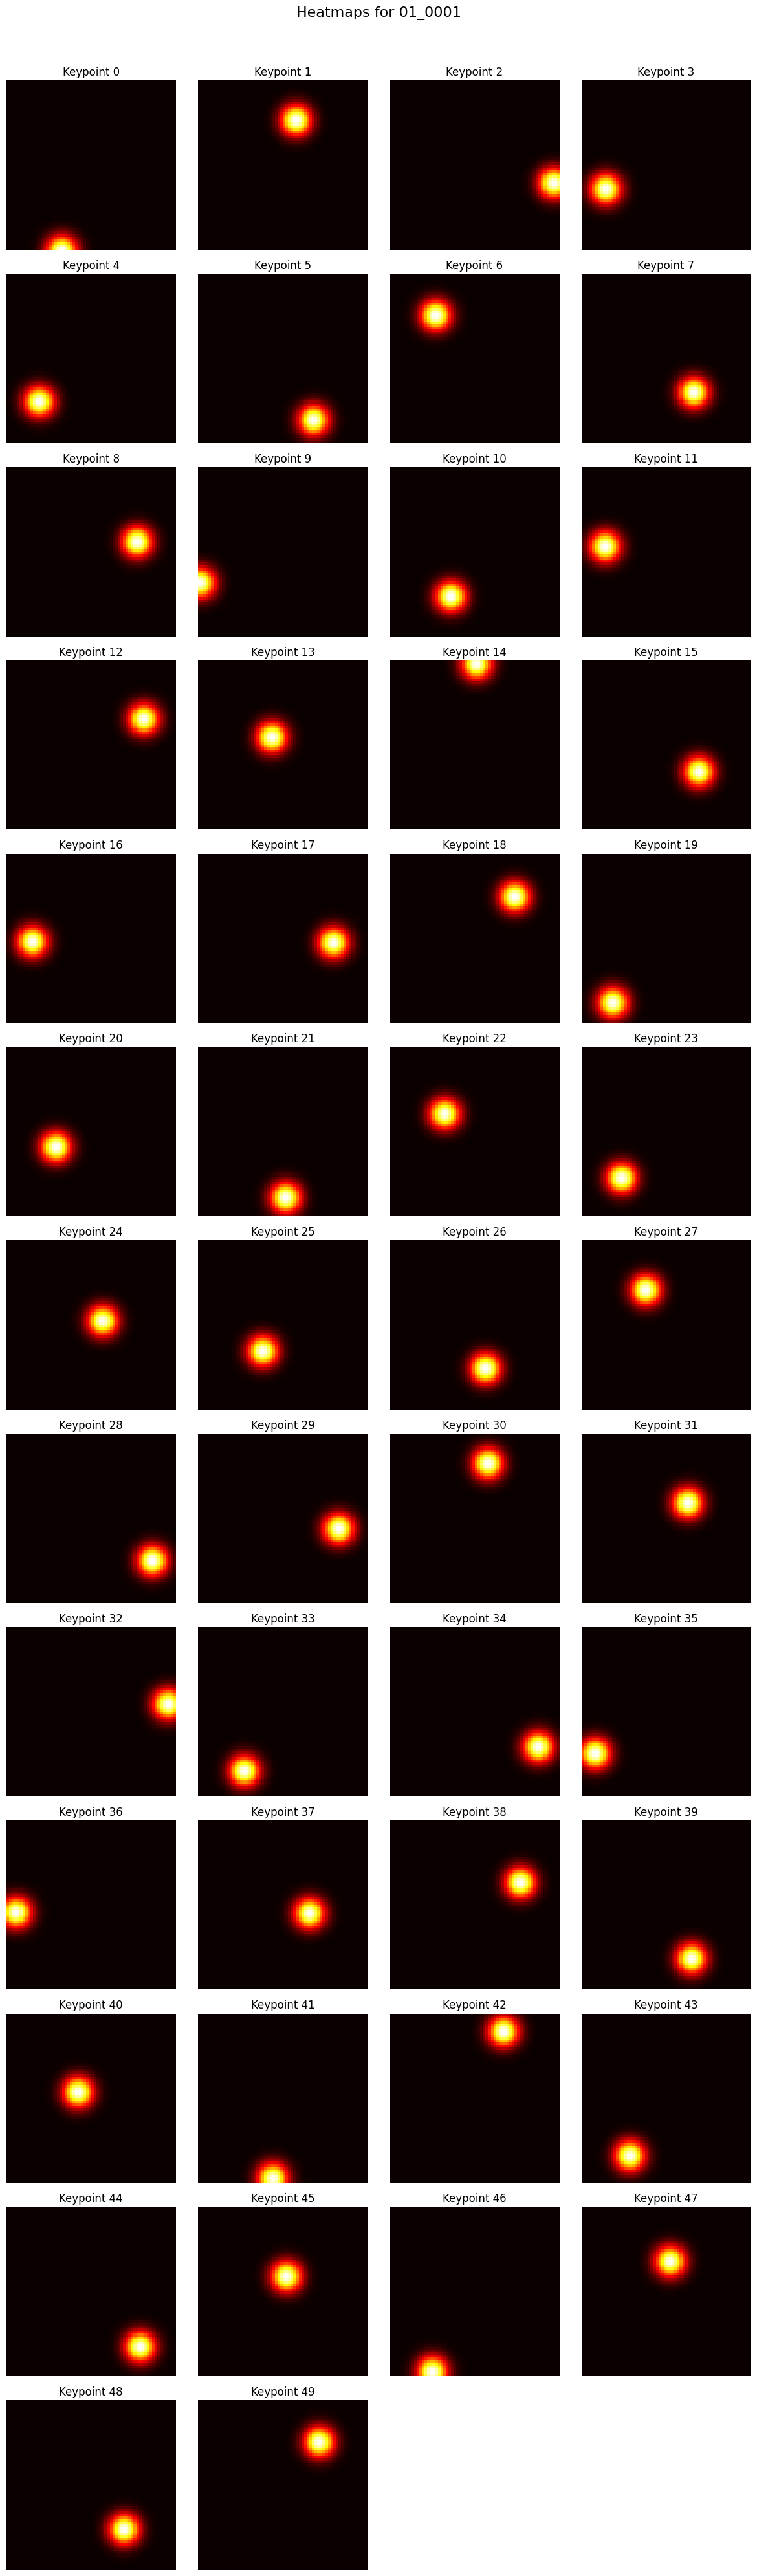

In [ ]:
compare_keypoints(
    image_id="01_0001",
    heatmap_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps"
    image_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data/",
    keypoints_json="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json"
)

show_heatmaps(
    image_id="01_0001",
    heatmap_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps"
)

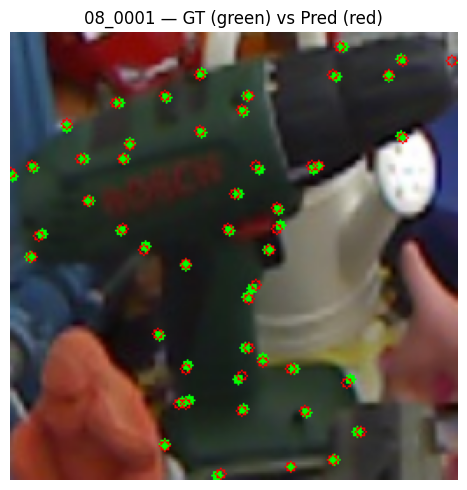

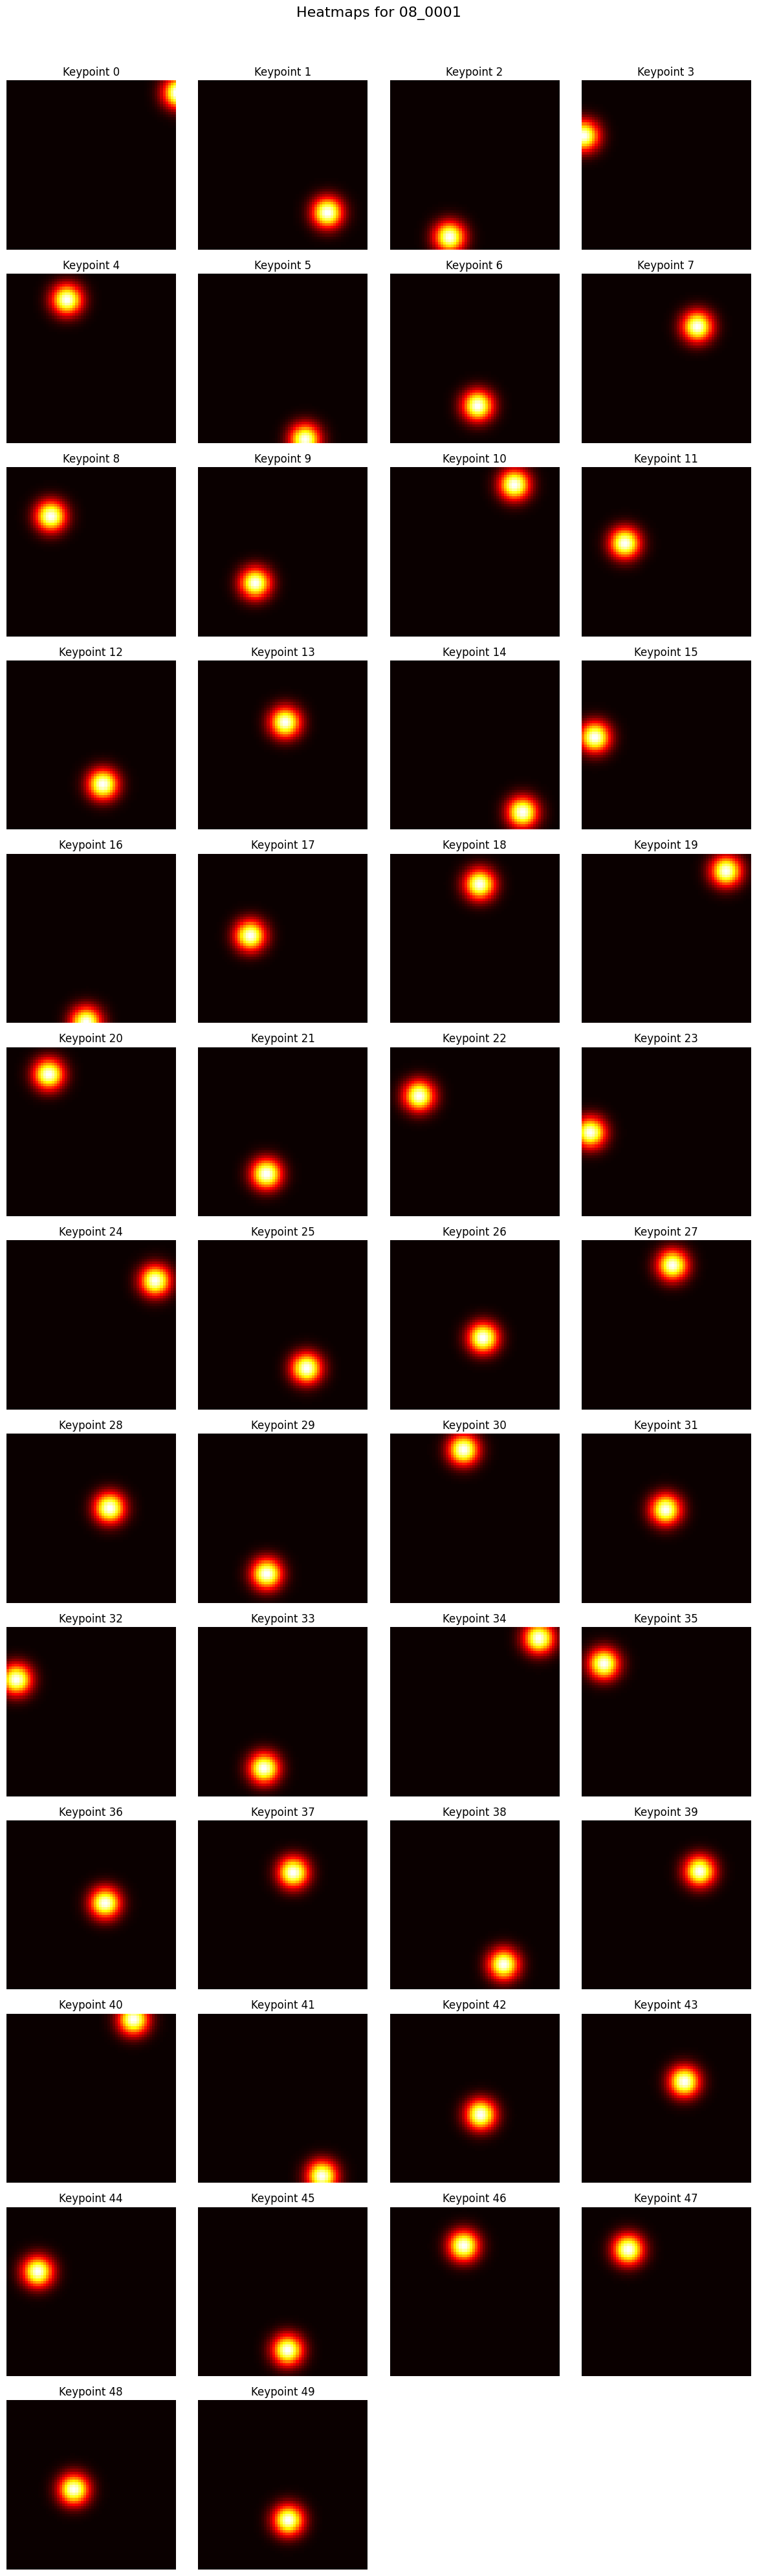

In [ ]:
compare_keypoints(
    image_id="08_0001",
    heatmap_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps",
    image_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data/",
    keypoints_json="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json"
)

show_heatmaps(
    image_id="08_0001",
    heatmap_dir="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_cps"
)

# Full Process Visualization

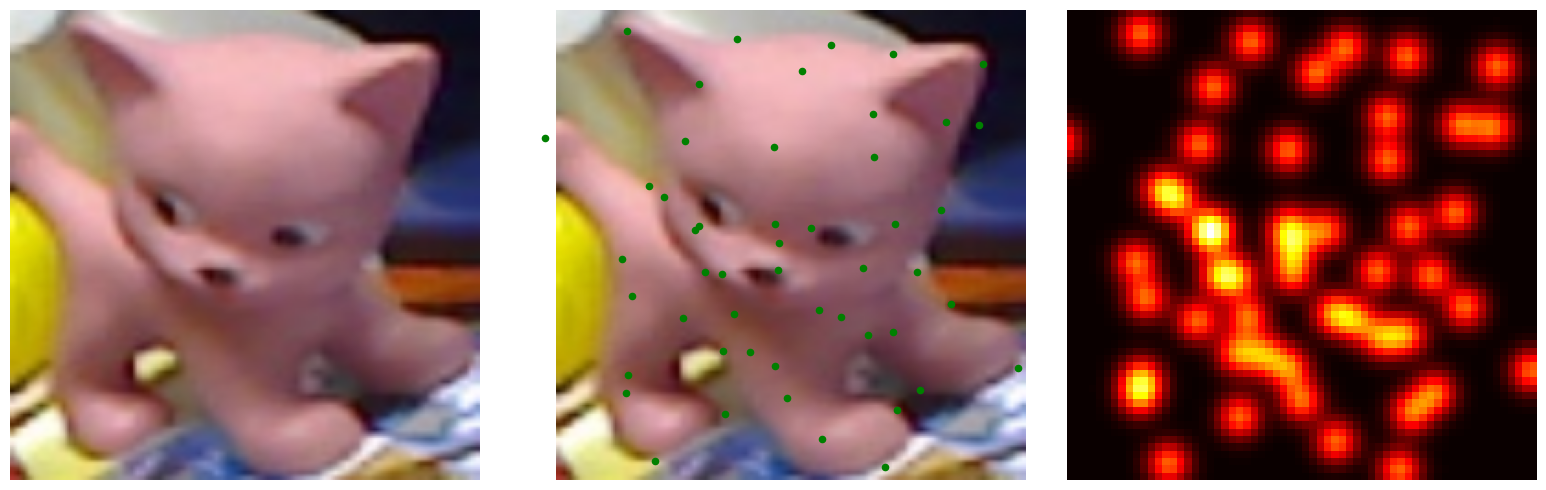

In [39]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# === SETTINGS ===
image_id = "06_0456"
image_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data/{image_id}.png"
fps_json_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json"
fps_heatmap_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_fps/{image_id}.pt"

# === Load image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Load keypoints
with open(fps_json_path, 'r') as f:
    fps_kps = json.load(f)
fps_points = np.array(fps_kps[image_id][:50])

# === Load and sum first 5 heatmaps
heatmaps = torch.load(fps_heatmap_path)[:50]
heatmap_sum = torch.sum(heatmaps, dim=0).numpy()

# === Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Figure A: Raw cropped image
axs[0].imshow(img_rgb)
axs[0].axis('off')

# Figure B: Image + keypoints
axs[1].imshow(img_rgb)
axs[1].scatter(fps_points[:, 0], fps_points[:, 1], color='green', s=20)
axs[1].axis('off')

# Figure C: Combined heatmap
axs[2].imshow(heatmap_sum, cmap='hot')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Distance Error

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def top_classes_by_difference(json_cps, json_fps, top_k=None):
    """
    Compares CPS and FPS 2D keypoints per class and reports average L2 distance.

    Parameters:
        json_cps (str): Path to CPS keypoints JSON.
        json_fps (str): Path to FPS keypoints JSON.
        top_k (int or None): Number of top classes to show. If None, show all.
    """
    with open(json_cps, "r") as f:
        cps_kps = json.load(f)
    with open(json_fps, "r") as f:
        fps_kps = json.load(f)

    shared_keys = list(set(cps_kps.keys()) & set(fps_kps.keys()))
    class_errors = defaultdict(list)

    for key in tqdm(shared_keys, desc="Computing class-wise differences"):
        class_str = key.split('_')[0]  # e.g., '01', '02'

        try:
            cps_pts = np.array(cps_kps[key])
            fps_pts = np.array(fps_kps[key])
            if cps_pts.shape != fps_pts.shape or cps_pts.shape[1] != 2:
                continue
            error = np.linalg.norm(cps_pts - fps_pts, axis=1).mean()
            class_errors[class_str].append(error)
        except Exception as e:
            print(f"[ERROR] {key}: {str(e)}")
            continue

    class_avg_errors = {
        cls: np.mean(errors) for cls, errors in class_errors.items()
    }

    sorted_errors = sorted(class_avg_errors.items(), key=lambda x: -x[1])
    if top_k:
        sorted_errors = sorted_errors[:top_k]

    print("\n🔝 Classes with largest CPS–FPS keypoint differences:")
    for cls, val in sorted_errors:
        print(f"Class {cls}: Avg Difference = {val:.2f} px")

In [ ]:
top_classes_by_difference(
    json_cps="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_cps.json",
    json_fps="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/2D_50_keypoints_labels_fps.json"
)

Computing class-wise differences: 100%|██████████| 14220/14220 [00:00<00:00, 23729.82it/s]



🔝 Classes with largest CPS–FPS keypoint differences:
Class 09: Avg Difference = 133.74 px
Class 12: Avg Difference = 130.89 px
Class 11: Avg Difference = 121.10 px
Class 13: Avg Difference = 120.94 px
Class 08: Avg Difference = 120.75 px
Class 10: Avg Difference = 118.93 px
Class 05: Avg Difference = 116.77 px
Class 04: Avg Difference = 116.18 px
Class 01: Avg Difference = 115.86 px
Class 15: Avg Difference = 115.20 px
Class 02: Avg Difference = 114.67 px
Class 06: Avg Difference = 113.63 px
Class 14: Avg Difference = 111.58 px
